In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.dummy import DummyClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.decomposition import PCA

from skopt.space import Integer, Real, Categorical
from skopt import BayesSearchCV
from scipy.stats import uniform, loguniform, randint

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
import pickle

In [2]:
line_df = pd.read_csv('../data/csv/ShakespeareCharacterLines_engineered.csv', index_col = ['play', 'name', 'line_number'])

In [3]:
char_df = pd.read_csv('../data/csv/ShakespeareCharacterLines_character_corpus.csv', index_col = ['play', 'name'])

In [4]:
colon = slice(None)

In [5]:
to_drop = list(line_df.columns[:10])
to_drop.remove('character_dies')

In [6]:
#df = line_df.drop(columns = to_drop).copy()
df = char_df.copy()

In [12]:
x_list = df.columns.tolist()
x_list.remove('character_dies')
X = df[x_list]
y = df['character_dies']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

sc = StandardScaler()
Xs_train = sc.fit_transform(X_train)
Xs_test = sc.transform(X_test)

93071902

- Baseline accuracy.

In [22]:
df['character_dies'].value_counts(normalize = True)

0.0    0.905958
1.0    0.094042
Name: character_dies, dtype: float64

In [13]:
logreg_pipe = Pipeline([
    ('sc', StandardScaler()),
    ('logreg', LogisticRegression(random_state = 42, solver = 'liblinear', penalty = 'l1'))
])

logreg_params = {
    'logreg__tol': uniform(0, .1),
    'logreg__C': loguniform(0.0001, 100),
    'logreg__class_weight': Categorical(['balanced', None]),
    'logreg__max_iter': randint(1, 1000),
    'logreg__l1_ratio': uniform(0, 1)
}

logreg_rs_rocauc = RandomizedSearchCV(estimator = logreg_pipe,
                     param_distributions = logreg_params,
                     scoring = 'roc_auc',
                     n_iter = 50,
                     n_jobs = 8,
                     cv = 5,
                     refit = True,
                     random_state=42)

In [14]:
%%time
logreg_rs_rocauc.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn("l1_ratio parameter is only used when penalty is "


Wall time: 6min 54s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('sc', StandardScaler()),
                                             ('logreg',
                                              LogisticRegression(penalty='l1',
                                                                 random_state=42,
                                                                 solver='liblinear'))]),
                   n_iter=50, n_jobs=8,
                   param_distributions={'logreg__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002B2C298A340>,
                                        'logreg__class_weight': Categorical(categories=('balanced', None), prior=None),
                                        'logreg__l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002B2C298A940>,
                                        'logreg__max_iter': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002B1A806BC10>,
                                     

In [16]:
train_preds = logreg_rs_rocauc.best_estimator_['logreg'].predict(Xs_train)
test_preds = logreg_rs_rocauc.best_estimator_['logreg'].predict(Xs_test)

metrics.roc_auc_score(y_train, train_preds), metrics.roc_auc_score(y_test, test_preds)

(0.7990356819260473, 0.7135596471039509)

In [17]:
weights = {key: value for key, value in zip(x_list, logreg_rs_rocauc.best_estimator_['logreg'].coef_[0])}
weights = {k: v for k, v in sorted(weights.items(), key=lambda item: item[1], reverse = True)}

In [18]:
weights

{'death_std': 0.12850891631837966,
 'unwelcome_person_hyp_std': 0.07553806786164316,
 'neg_sentiment_std': 0.06891258369021096,
 'ah_std': 0.056450769581478766,
 'INTJ_std': 0.05121047413502336,
 'life_std': 0.050121440951676435,
 'denmark_syn_std': 0.043529132855568815,
 'word_std': 0.03470232159352246,
 'brow_std': 0.03214397083347529,
 'revenge_std': 0.031231511595154398,
 'mean_std': 0.025622324887338583,
 'eunuch_std': 0.02516520401919758,
 'win_hyp_std': 0.02442470233452667,
 'tragedy_std': 0.023730703162129035,
 'son_std': 0.018765378625682883,
 'abused_std': 0.018638307656687742,
 'murder_std': 0.017986973946210252,
 'being_hyp_std': 0.017760066284526407,
 'express_emotion_hyp_std': 0.01693803887373723,
 'villain_std': 0.01620860183951193,
 'dig_mean': 0.01565939980957762,
 'misconstrue_std': 0.014996624343505533,
 'unadvise_std': 0.0139210492888509,
 'undergo_hyp_mean': 0.01389503467035266,
 'standing_hyp_std': 0.01384963142253865,
 'writer_hyp_std': 0.012609478055652306,
 'ge

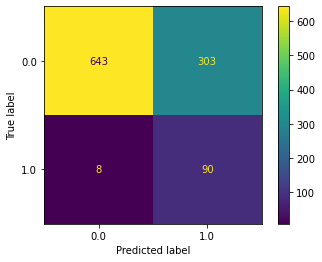

In [21]:
plot_confusion_matrix(logreg_rs_rocauc.best_estimator_['logreg'], Xs_train, y_train)

In [23]:
et_pipe = Pipeline([
    ('et', ExtraTreesClassifier(random_state = 42))
])

et_params = {
    'et__criterion': Categorical(['gini', 'entropy']),
    'et__n_estimators': randint(5, 200),
    'et__min_samples_split': uniform(0, .5),
    'et__min_samples_leaf': uniform(0, .5),
    'et__max_depth': randint(1, 100),
    'et__max_features': Categorical(['auto', 'sqrt', 'log2']),
    'et__min_impurity_decrease': uniform(0, .2),
    'et__ccp_alpha':  uniform(0, .2),
    'et__max_samples':  uniform(0, 1)
}

et_rs_rocauc = RandomizedSearchCV(estimator = et_pipe,
                     param_distributions = et_params,
                     scoring = 'roc_auc',
                     n_iter = 100,
                     cv = 5,
                     refit = True,
                     n_jobs = 8,
                     random_state=42)

In [24]:
%%time
et_rs_rocauc.fit(X_train, y_train)

Wall time: 1min 47s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('et',
                                              ExtraTreesClassifier(random_state=42))]),
                   n_iter=100, n_jobs=8,
                   param_distributions={'et__ccp_alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002B1F1675580>,
                                        'et__criterion': Categorical(categories=('gini', 'entropy'), prior=None),
                                        'et__max_depth': <scipy.stats._distn_infrastructure.rv_...
                                        'et__min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002B1F16752B0>,
                                        'et__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002B1F166AD00>,
                                        'et__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002B1F166A940>,
                      

In [25]:
et_rs_rocauc.best_estimator_.score(X_train, y_train), et_rs_rocauc.best_estimator_.score(X_test, y_test)

(0.9061302681992337, 0.9054441260744985)

In [26]:
et_rs_rocauc.best_estimator_['et']

ExtraTreesClassifier(ccp_alpha=0.0749080237694725, criterion='entropy',
                     max_depth=72, max_features='sqrt',
                     max_samples=0.15601864044243652,
                     min_impurity_decrease=0.031198904067240532,
                     min_samples_leaf=0.02904180608409973,
                     min_samples_split=0.4330880728874676, n_estimators=104,
                     random_state=42)

In [27]:
features = {key: value for key, value in zip(x_list, et_rs_rocauc.best_estimator_['et'].feature_importances_)}
features = {k: v for k, v in sorted(features.items(), key=lambda item: item[1], reverse = True)}

In [28]:
features

{'pos_sentiment_mean': 0.0,
 'neg_sentiment_mean': 0.0,
 'neu_sentiment_mean': 0.0,
 'compound_sentiment_mean': 0.0,
 'endowment_hyp_mean': 0.0,
 'hang_mean': 0.0,
 'VERB_mean': 0.0,
 'character_name_mean': 0.0,
 'PROPN_mean': 0.0,
 'shall_mean': 0.0,
 'attempt_hyp_mean': 0.0,
 'good_mean': 0.0,
 'ADJ_mean': 0.0,
 'by_and_large_syn_mean': 0.0,
 'generally_mean': 0.0,
 'ADV_mean': 0.0,
 'match_hyp_mean': 0.0,
 'accord_mean': 0.0,
 'security_hyp_mean': 0.0,
 'scrip_mean': 0.0,
 'advantage_hyp_mean': 0.0,
 'dramatic_composition_hyp_mean': 0.0,
 'play_mean': 0.0,
 'NOUN_mean': 0.0,
 'nutriment_hyp_mean': 0.0,
 'treat_mean': 0.0,
 'publication_hyp_mean': 0.0,
 'read_mean': 0.0,
 'defamation_hyp_mean': 0.0,
 'name_mean': 0.0,
 'performer_hyp_mean': 0.0,
 'actor_mean': 0.0,
 'change_hyp_mean': 0.0,
 'grow_mean': 0.0,
 'component_hyp_mean': 0.0,
 'point_mean': 0.0,
 'part_hyp_mean': 0.0,
 'piece_mean': 0.0,
 'activity_hyp_mean': 0.0,
 'work_mean': 0.0,
 'guarantee_syn_mean': 0.0,
 'assure_mean

In [37]:
pca = PCA(random_state = 42)
Z_train = pca.fit_transform(Xs_train)
Z_test = pca.transform(Xs_test)
explained_variance = pca.explained_variance_ratio_

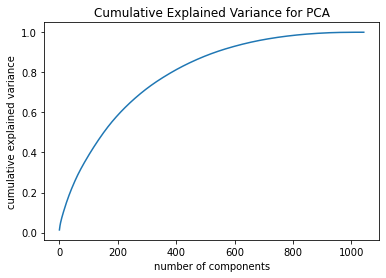

In [38]:
plt.plot(np.cumsum(explained_variance))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('Cumulative Explained Variance for PCA');

In [40]:
pca = PCA(n_components = 1000, random_state = 42)
Z_train = pca.fit_transform(Xs_train)
Z_test = pca.transform(Xs_test)

In [46]:
%%time

model = Sequential()

model.add(Dense(8, activation = 'relu', input_shape = (1000,)))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam')

history = model.fit(Z_train, y_train, validation_data = (Z_test, y_test), batch_size = 512, 
                   epochs = 1000)

Epoch 1/1000
3/3 [==============================] - 0s 32ms/step - loss: 1.3945 - val_loss: 0.8939
Epoch 2/1000
3/3 [==============================] - 0s 4ms/step - loss: 1.1782 - val_loss: 0.8572
Epoch 3/1000
3/3 [==============================] - 0s 5ms/step - loss: 1.0362 - val_loss: 0.8235
Epoch 4/1000
3/3 [==============================] - 0s 4ms/step - loss: 0.9199 - val_loss: 0.7940
Epoch 5/1000
3/3 [==============================] - 0s 4ms/step - loss: 0.8257 - val_loss: 0.7681
Epoch 6/1000
3/3 [==============================] - 0s 5ms/step - loss: 0.7444 - val_loss: 0.7449
Epoch 7/1000
3/3 [==============================] - 0s 4ms/step - loss: 0.6765 - val_loss: 0.7215
Epoch 8/1000
3/3 [==============================] - 0s 4ms/step - loss: 0.6195 - val_loss: 0.6997
Epoch 9/1000
3/3 [==============================] - 0s 4ms/step - loss: 0.5675 - val_loss: 0.6805
Epoch 10/1000
3/3 [==============================] - 0s 4ms/step - loss: 0.5235 - val_loss: 0.6629
Epoch 11/1000
3/3 

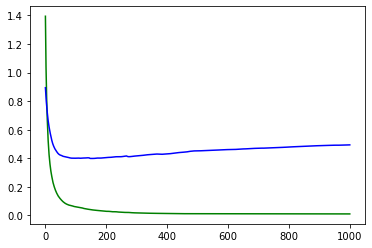

In [47]:
plt.plot(history.epoch, history.history['loss'], c='g');      # green - training loss # Loss
plt.plot(history.epoch, history.history['val_loss'], c='b');  # blue - test loss # Val loss

In [ ]:
#credit to: lesson 7.6
def model_func(layers, loss_fn = 'binary_crossentropy'):
    
    model = Sequential()

    flag_first = True
    
    for layer in layers:
        if flag_first:
            model.add(Dense(layer, activation = 'relu', input_shape = (14258,)))
            flag_first = False
        else:
            model.add(Dense(layer, activation = 'relu'))
    
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss = loss_fn, optimizer = 'adam')
    
    return model

nn = KerasClassifier(build_fn = model, batch_size = 512, epochs = 20, verbose = 0)

params = {'batch_size': [126, 512],
          'epochs': [10, 15, 20]
         }

grid = GridSearchCV(nn, params, cv = 3, n_jobs = -1)

In [ ]:
%%time
sc = StandardScaler()
Xs_train = sc.fit_transform(X_train)
grid.fit(Xs_train, y_train)